In [1]:
%matplotlib inline
import math
import scipy
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf

In [2]:
# Read excel file in to dataframe
crimes_raw = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)
crimes_raw.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [49]:
# Clean the dataframe according to specifications: population, population**2, murder, robbery
crimes = pd.DataFrame()

crimes['city'] = crimes_raw['City']
crimes['population'] = crimes_raw['Population']
crimes['population_sq'] = (crimes_raw['Population'])**2
crimes['murder'] = crimes_raw['Murder and\nnonnegligent\nmanslaughter']
crimes['robbery'] = crimes_raw['Robbery']
    
crimes.head()


,city,population,population_sq,murder,robbery
0,Adams Village,1861.0,3.463321e+06,0.0,0.0
1,Addison Town and Village,2577.0,6.640929e+06,0.0,0.0
2,Akron Village,2846.0,8.099716e+06,0.0,0.0
3,Albany,97956.0,9.595378e+09,8.0,227.0
4,Albion Village,6388.0,4.080654e+07,0.0,4.0


In [50]:
# Now let's format the murder and robbery columns to a boolean
crimes['murder'] = crimes.apply(lambda row: True if row['murder'] > 0 else False, axis=1)
crimes['robbery'] = crimes.apply(lambda row: True if row['robbery'] > 0 else False, axis=1)

crimes.head()

,city,population,population_sq,murder,robbery
0,Adams Village,1861.0,3.463321e+06,False,False
1,Addison Town and Village,2577.0,6.640929e+06,False,False
2,Akron Village,2846.0,8.099716e+06,False,False
3,Albany,97956.0,9.595378e+09,True,True
4,Albion Village,6388.0,4.080654e+07,False,True


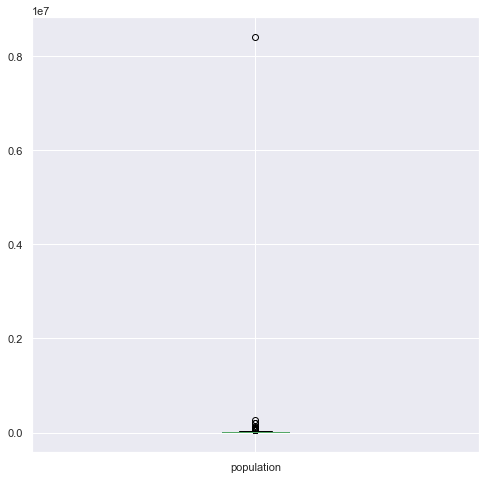

In [51]:
f, ax = plt.subplots(figsize=(8, 8))
crimes.boxplot(column='population')


#### Looks like we have a pretty significant outlier in our data. Let's find out which datapoint/s is causing this.

In [52]:
crimes['population'].describe()

count    3.480000e+02
mean     4.003763e+04
std      4.500374e+05
min      5.260000e+02
25%      3.003000e+03
50%      7.233500e+03
75%      1.842750e+04
max      8.396126e+06
Name: population, dtype: float64

#### So the population ranges from 526 to 8.3 million. But the mean is around 4000 so let's dig deaper.

In [53]:
# First let's find the row that contains the max population value
print(crimes.iloc[crimes['population'].idxmax()])

city                New York
population       8.39613e+06
population_sq    7.04949e+13
murder                  True
robbery                 True
Name: 216, dtype: object


#### Population drops off significantly from position 1 to 2. Let's remove the NYC data and see if the box plot becomes more readable.

In [54]:
crimes_no_nyc = crimes.drop([216])
crimes_no_nyc.describe()

,population,population_sq
count,347.000000,3.470000e+02
mean,15956.685879,9.858407e+08
std,27080.218837,5.067232e+09
min,526.000000,2.766760e+05
25%,2997.000000,8.982153e+06
50%,7187.000000,5.165297e+07
75%,18160.500000,3.298042e+08
max,258789.000000,6.697175e+10


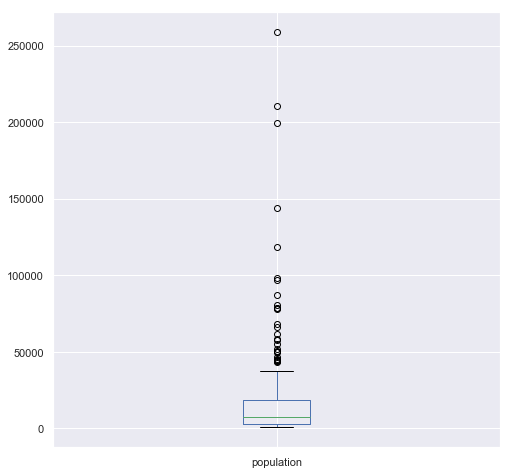

In [55]:
f, ax = plt.subplots(figsize=(8, 8))
crimes_no_nyc.boxplot(column='population')
# QUESTION: What is the difference between above method and plt.boxplot(df[crimes_no_nyc].population)

#### Yay! More outliers. Let's see what happens when we group these outliers with the NYC data.

In [56]:
# First calculate figure for upper whisker
# since whiskers are 1.5*IQR
q1 = crimes_no_nyc['population'].quantile(.25)
q3 = crimes_no_nyc['population'].quantile(.75)

upper_whisker = q3+(1.5*(q3-q1))
print(upper_whisker)

40905.75


In [57]:
# Now move cities with population greater than upper whisker to a separate dataframe
crimes_big_cities = crimes[crimes['population'] > 40906]
print(crimes_big_cities.head())
print(crimes_big_cities.shape)

                city  population  population_sq  murder  robbery
3             Albany     97956.0   9.595378e+09    True     True
7       Amherst Town    118296.0   1.399394e+10    True     True
22        Binghamton     46304.0   2.144060e+09    True     True
35           Buffalo    258789.0   6.697175e+10    True     True
53  Cheektowaga Town     78361.0   6.140446e+09   False     True
(30, 5)


In [58]:
# And move cities with population smaller than upper whisker to a separate dataframe
crimes_small_cities = crimes[crimes['population'] < 40906]
print(crimes_small_cities.head())
print(crimes_small_cities.shape)

                       city  population  population_sq  murder  robbery
0             Adams Village      1861.0      3463321.0   False    False
1  Addison Town and Village      2577.0      6640929.0   False    False
2             Akron Village      2846.0      8099716.0   False    False
4            Albion Village      6388.0     40806544.0   False     True
5            Alfred Village      4089.0     16719921.0   False     True
(318, 5)


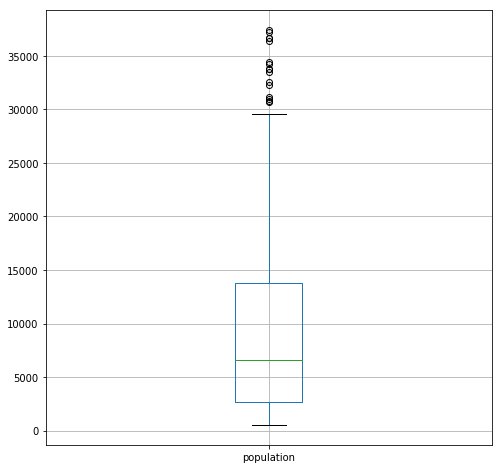

In [13]:
# Plot both sets
f, axes = plt.subplots(figsize=[8, 8])
crimes_small_cities.boxplot(column='population')

#### Looks like if we keep going down this rabbit hole, we are just going to be slicing the data into thinner and thinner pieces. It could be useful to divide the data into 3-4 different categories according to the population. But for now we will just exclude NYC since the number is so much greater that plots become meaningless and indistinguishable. And we can safely assume that a city similar to the size of NYC will definitely have at least one murder and at least one robbery in a year.

In [59]:
# Make another column to make plotting a little easier
crimes.loc[(crimes['murder'] == True), 'crime_type'] = 'murder'
crimes.loc[crimes['robbery'] == True, 'crime_type'] = 'robbery'
crimes.loc[(crimes['robbery'] == True) & (crimes['murder'] == True), 'crime_type'] = 'both'
crimes.loc[(crimes['murder'] == False) & (crimes['robbery'] == False), 'crime_type'] = 'none'

# Now copy to crimes_no_nyc
crimes_no_nyc = crimes.drop([216])
crimes_no_nyc.head(10)

,city,population,population_sq,murder,robbery,crime_type
0,Adams Village,1861.0,3.463321e+06,False,False,none
1,Addison Town and Village,2577.0,6.640929e+06,False,False,none
2,Akron Village,2846.0,8.099716e+06,False,False,none
3,Albany,97956.0,9.595378e+09,True,True,both
4,Albion Village,6388.0,4.080654e+07,False,True,robbery
5,Alfred Village,4089.0,1.671992e+07,False,True,robbery
6,Allegany Village,1781.0,3.171961e+06,False,False,none
7,Amherst Town,118296.0,1.399394e+10,True,True,both
8,Amityville Village,9519.0,9.061136e+07,False,True,robbery
9,Amsterdam,18182.0,3.305851e+08,False,True,robbery


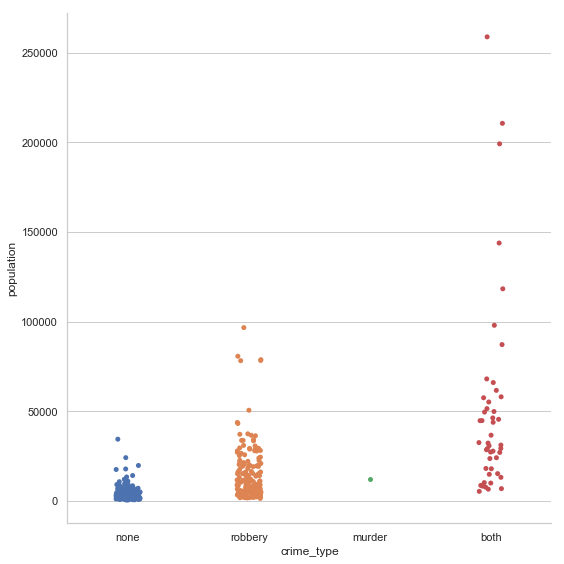

In [60]:
# Let's make a scatter plot to see the relationships between the variables
sns.set(style='whitegrid')
sns.catplot(x='crime_type', y='population', data=crimes_no_nyc, order=['none', 'robbery', 'murder', 'both'], height=8)
plt.show()

#### But since what we actually want is to predict property crimes, let's change up the data a little bit.

In [68]:
# First, let's include property crimes figures. This will be our outcome variable.
# And I want to leave the murder and robbery columns as continuous
crimes['property_crimes'] = crimes_raw['Property\ncrime']
crimes['murder'] = crimes_raw['Murder and\nnonnegligent\nmanslaughter']
crimes['robbery'] = crimes_raw['Robbery']
crimes.head()

crimes_no_nyc = crimes.drop([216])

#### Let's fit our data into a linear regression model

In [69]:
crimes_no_nyc.describe()

,population,population_sq,murder,robbery,property_crimes
count,347.000000,3.470000e+02,347.000000,347.000000,347.000000
mean,15956.685879,9.858407e+08,0.605187,17.867435,385.752161
std,27080.218837,5.067232e+09,3.707090,94.972492,1034.369072
min,526.000000,2.766760e+05,0.000000,0.000000,0.000000
25%,2997.000000,8.982153e+06,0.000000,0.000000,40.000000
50%,7187.000000,5.165297e+07,0.000000,1.000000,112.000000
75%,18160.500000,3.298042e+08,0.000000,5.000000,340.500000
max,258789.000000,6.697175e+10,47.000000,1322.000000,12491.000000


In [63]:
crimes_no_nyc.shape

(350, 7)

In [121]:
crimes_no_nyc.index[crimes_no_nyc.isnull().any(axis=1)]

Int64Index([348, 349, 350], dtype='int64')

In [125]:
# Drop rows with null values
crimes_no_nyc = crimes_no_nyc.drop(crimes_no_nyc.index[crimes_no_nyc.isnull().any(axis=1)])
crimes_no_nyc.shape

(347, 9)

In [132]:
regr = linear_model.LinearRegression()
#Y = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)]['property_crimes'].values.reshape(-1, 1)
#X1 = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)][['population', 'population_sq', 'murder', 'robbery']]
Y = crimes_no_nyc.values.reshape(-1, 1)
X1 = crimes_no_nyc[['population', 'population_sq', 'murder', 'robbery']]
print(X1)

regr1 = regr.fit(X1, Y)

     population  population_sq  murder  robbery
0        1861.0   3.463321e+06     0.0      0.0
1        2577.0   6.640929e+06     0.0      0.0
2        2846.0   8.099716e+06     0.0      0.0
3       97956.0   9.595378e+09     8.0    227.0
4        6388.0   4.080654e+07     0.0      4.0
5        4089.0   1.671992e+07     0.0      3.0
6        1781.0   3.171961e+06     0.0      0.0
7      118296.0   1.399394e+10     1.0     31.0
8        9519.0   9.061136e+07     0.0      4.0
9       18182.0   3.305851e+08     0.0     12.0
10       2053.0   4.214809e+06     0.0      0.0
11       4523.0   2.045753e+07     0.0      3.0
12        658.0   4.329640e+05     0.0      0.0
13       2522.0   6.360484e+06     0.0      0.0
14      27270.0   7.436529e+08     1.0     22.0
15       3333.0   1.110889e+07     0.0      1.0
16       7473.0   5.584573e+07     0.0      1.0
17       5418.0   2.935472e+07     0.0      3.0
18      15374.0   2.363599e+08     0.0     13.0
19       5733.0   3.286729e+07     0.0  

ValueError: could not convert string to float: 'Adams Village'

In [67]:
# Coefficients
coef1 = regr1.coef_

# Intercept
intercept1 = regr1.intercept_

# R-Squared
score1 = regr1.score(X1, Y)

stats = {'intercept': intercept1[0],
           'b1': coef1[0][0],
           'b2': coef1[0][1],
           'b3': coef1[0][2],
           'b4': coef1[0][3],
           'R-sqr': score1},
            
math = pd.DataFrame(stats)
math

,R-sqr,b1,b2,b3,b4,intercept
0,0.939283,0.020552,-7.194683e-08,102.643383,5.130014,-25.039858


#### R-squared value shows that this model can explain about 94% of our data. and it looks like the number of robberies is the biggest indicator in predicting property crimes in this model. The intercept in our model is a negative number, meaning there is a threshold of combinations of our features after which property crime will start occurring.

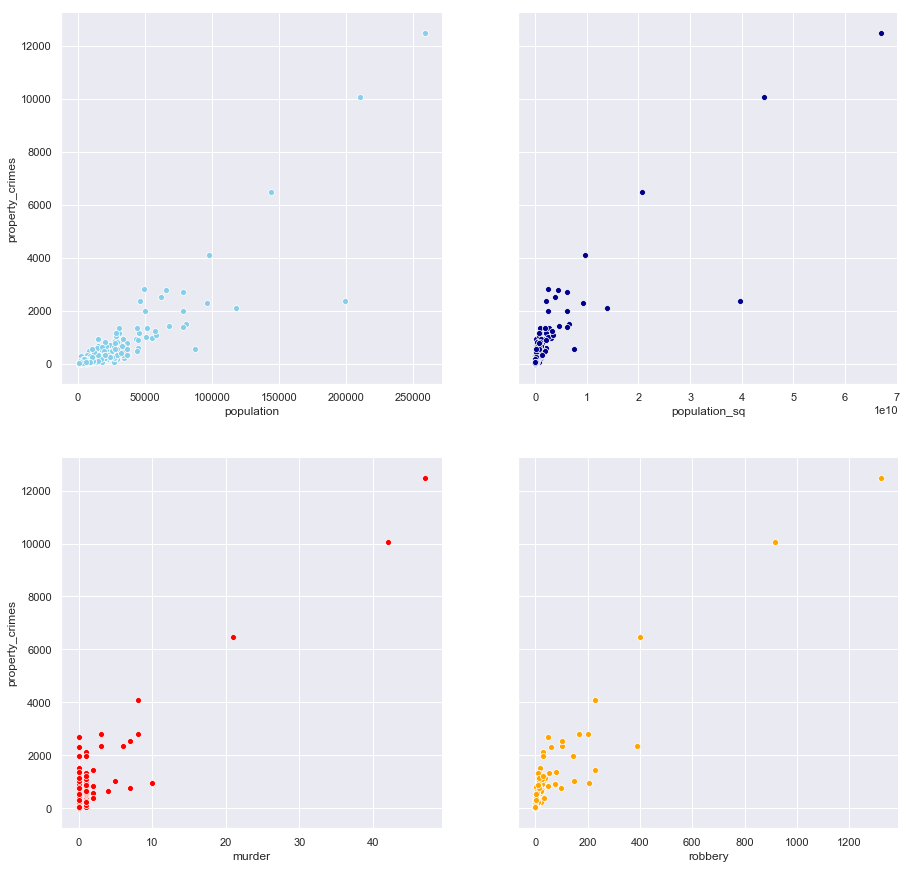

In [71]:
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
sns.set(style='darkgrid')
sns.despine()

data = crimes_no_nyc
y = 'property_crimes'
x1 = 'population'
x2 = 'population_sq'
x3 = 'murder'
x4 = 'robbery'

ax1 = axes[0, 0]
ax1 = sns.scatterplot(x=x1, y=y, data=data, ax=ax1, color='skyblue')

ax2 = axes[0, 1]
ax2 = sns.scatterplot(x=x2, y=y, data=data, ax=ax2, color='darkblue')

ax3 = axes[1, 0]
ax3 = sns.scatterplot(x=x3, y=y, data=data, ax=ax3, color='red')

ax4 = axes[1, 1]
ax4 = sns.scatterplot(x=x4, y=y, data=data, ax=ax4, color='orange')

plt.show()

### Checking Linearity

#### I want to see if I can make these plots a little more linear.

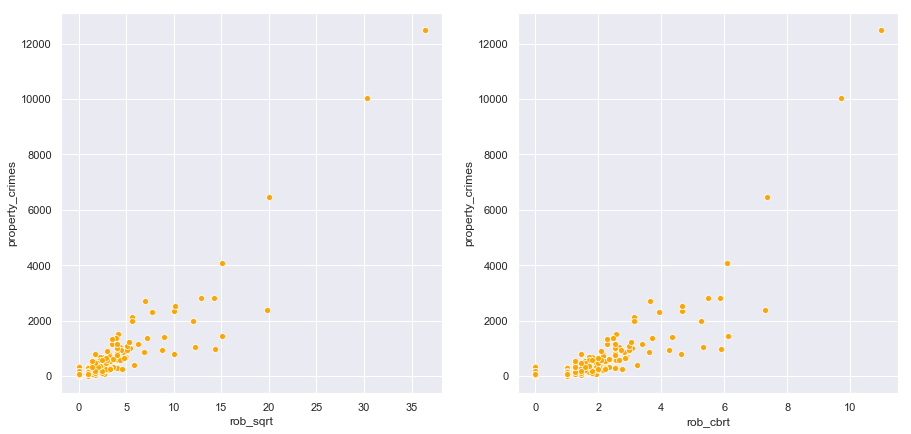

In [72]:
# For robbery column
crimes_no_nyc['rob_sqrt'] = np.sqrt(crimes_no_nyc['robbery'])
crimes_no_nyc['rob_cbrt'] = np.cbrt(crimes_no_nyc['robbery'])

f, axes = plt.subplots(1, 2, figsize=(15, 7))

ax1 = axes[0]
ax1 = sns.scatterplot(x='rob_sqrt', y=y, data=data, ax=ax1, color='orange')

ax2 = axes[1]
ax2 = sns.scatterplot(x='rob_cbrt', y=y, data=data, ax=ax2, color='orange')

plt.show()

#### I think square root value is the lucky winner.

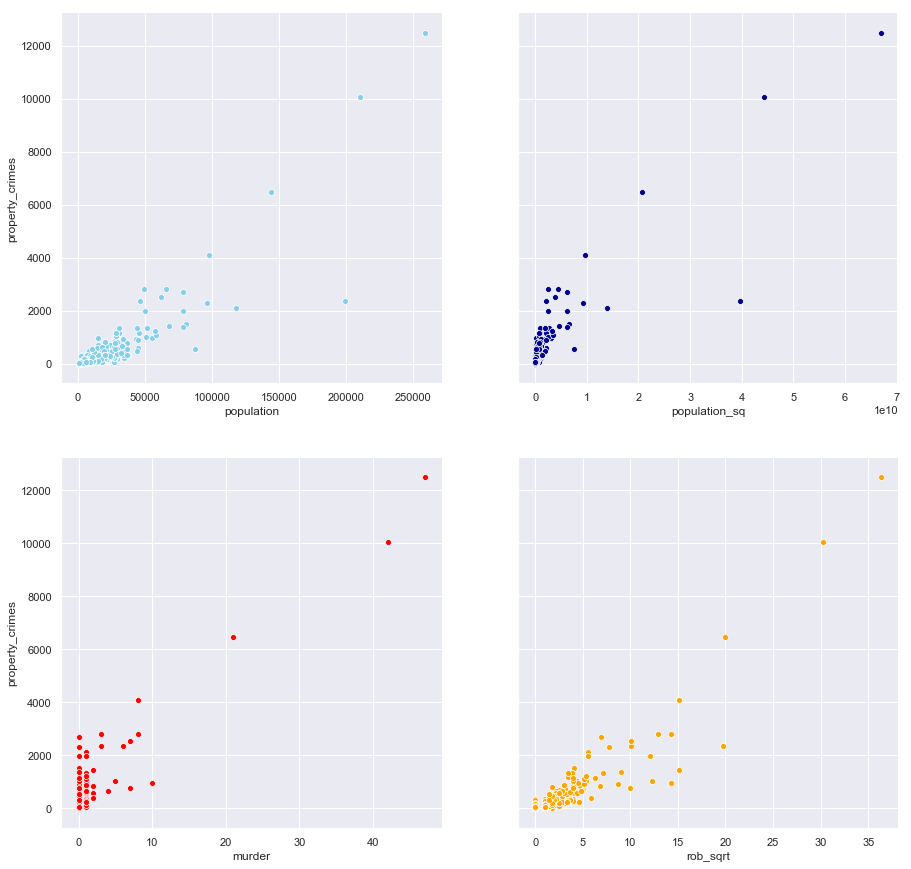

In [73]:
# Let's try plotting again
f, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
sns.set(style='darkgrid')
sns.despine()

ax1 = axes[0, 0]
ax1 = sns.scatterplot(x=x1, y=y, data=data, ax=ax1, color='skyblue')

ax2 = axes[0, 1]
ax2 = sns.scatterplot(x=x2, y=y, data=data, ax=ax2, color='darkblue')

ax3 = axes[1, 0]
ax3 = sns.scatterplot(x=x3, y=y, data=data, ax=ax3, color='red')

ax4 = axes[1, 1]
ax4 = sns.scatterplot(x='rob_sqrt', y=y, data=data, ax=ax4, color='orange')

plt.show()

#### Ahh, that looks better. Now let's check the stats again with improved features.

In [74]:
regr = linear_model.LinearRegression()
Y = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)]['property_crimes'].values.reshape(-1, 1)
X2 = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)][['population', 'population_sq', 'murder', 'rob_sqrt']]
regr2 = regr.fit(X2, Y)

In [75]:
# Coefficients
coef2 = regr2.coef_

# Intercept
intercept2 = regr2.intercept_

# R-Squared
score2 = regr2.score(X2, Y)

stats2 = {'intercept': intercept2[0],
           'b1': coef2[0][0],
           'b2': coef2[0][1],
           'b3': coef2[0][2],
           'b4': coef2[0][3],
           'R-sqr': score1},

math2 = pd.DataFrame(stats2)
math.append(math2)


,R-sqr,b1,b2,b3,b4,intercept
0,0.939283,0.020552,-7.194683e-08,102.643383,5.130014,-25.039858
0,0.939283,0.014304,-1.518193e-08,152.785107,51.217432,-21.164177


### Multivariate Normality

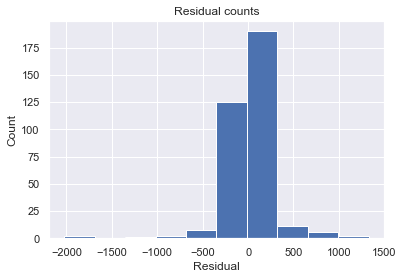

In [76]:
# Extract predicted values.
predicted = regr2.predict(X2).ravel()
actual = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)]['property_crimes']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#### That looks pretty darn close to a normal distribution.

### Homoscedacity: checking to see if the error terms are consistently distributed

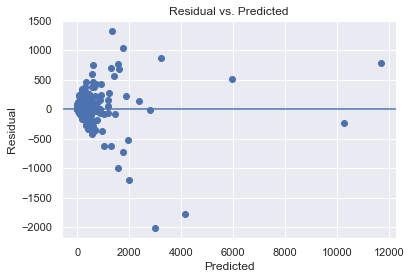

In [77]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#### Hmm... this doesn't look good. There are a few outliers that may need to be dealt with.

### Low multicolinearity

In [78]:
# Check correlation
correlation_matrix = X2.corr()
display(correlation_matrix)

,population,population_sq,murder,rob_sqrt
population,1.000000,0.888582,0.756401,0.888661
population_sq,0.888582,1.000000,0.883650,0.815992
murder,0.756401,0.883650,1.000000,0.820394
rob_sqrt,0.888661,0.815992,0.820394,1.000000


#### Those are some very high correlations. 

## Lesson 5: Testing our model

In [111]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula1 = 'property_crimes ~ population+population_sq+murder+rob_sqrt'
data = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)]

# Fit the model to our data using the formula.
lm1 = smf.ols(formula=linear_formula1, data=data).fit()


,city,population,population_sq,murder,robbery,crime_type,property_crimes,rob_sqrt,rob_cbrt
0,Adams Village,1861.0,3.463321e+06,0.0,0.0,none,12.0,0.000000,0.000000
1,Addison Town and Village,2577.0,6.640929e+06,0.0,0.0,none,24.0,0.000000,0.000000
2,Akron Village,2846.0,8.099716e+06,0.0,0.0,none,16.0,0.000000,0.000000
3,Albany,97956.0,9.595378e+09,8.0,227.0,both,4090.0,15.066519,6.100170
4,Albion Village,6388.0,4.080654e+07,0.0,4.0,robbery,223.0,2.000000,1.587401


In [95]:
# Coefficients
coef1 = lm1.params
print(coef1)

Intercept       -2.116418e+01
population       1.430404e-02
population_sq   -1.518193e-08
murder           1.527851e+02
rob_sqrt         5.121743e+01
dtype: float64


In [96]:
# P-values(siginificance testing for each of the features)
p_val1 = lm1.pvalues
print(p_val1)

Intercept        2.750293e-01
population       2.864577e-16
population_sq    1.000300e-01
murder           4.075809e-40
rob_sqrt         7.737670e-07
dtype: float64


In [101]:
# Let's check the R-squared value
r_sq1 = lm1.rsquared
print(r_sq1)

0.936014565950366


#### P-value for population_sq is 0.10 (α < 0.05) shows that this feature is not very significant in explaining the variance in our model so let's drop it.

In [97]:
linear_formula2 = 'property_crimes ~ population+murder+rob_sqrt'

# Fit a new line
lm2 = smf.ols(formula=linear_formula2, data=data).fit()

# Display the new coefficients
coef2 = lm2.params
print('Coefficients: \n', coef2)

Coefficients: 
 Intercept      -8.911817
population      0.012316
murder        140.403053
rob_sqrt       57.286853
dtype: float64


In [98]:
# New p-values
p_val2 = lm2.pvalues
print(p_val2)

Intercept     6.192944e-01
population    2.470397e-23
murder        5.154524e-63
rob_sqrt      4.334637e-09
dtype: float64


#### Let's check the R-squared value again

In [102]:
r_sq2 = lm2.rsquared
print(r_sq2)

0.9355057176266391


#### So removing the population_sq feature only lowered the R-squared value by ~0.005%. So let's move forward with this model and check to see if it works well with other data.

In [115]:
regr = linear_model.LinearRegression()
Y = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)]['property_crimes'].values.reshape(-1, 1)
X3 = crimes_no_nyc[~crimes_no_nyc.isnull().any(axis=1)][['population', 'murder', 'rob_sqrt']]
regr3 = regr.fit(X3, Y)

In [118]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# We need to specify the outcomes(target) and input(data)
target1 = data['property_crimes']

# Classify, storing the result in a new variable.
y_pred = lm2.predict(data)

# Get cross-validation scores 
cvs1 = cross_val_score(regr, X3, Y, cv=10)
print(cvs1)
cm1 = confusion_matrix(target1, y_pred)
print(cm1)

# Find the sensitivity (TPos/sum(TPos and FPos)) and specificity(TNeg/sum(TNeg and FNeg))
sens_yelp_1 = cm_yelp_1[0, 0]/sum(cm_yelp_1[0])
print('Sensitivity: ', sens_yelp_1)

spec_yelp_1 = cm_yelp_1[1,1]/sum(cm_yelp_1[1])
print('Specifity: ', spec_yelp_1)

[ 0.91945531  0.97181966  0.59582521  0.80654817 -0.14965959  0.53828308
  0.72145761  0.96498593  0.97641669  0.46465209]


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets